**Engy-5050** Reactor Physics, UMass Lowell, Chem. Eng. Nuclear Program Spring 2022; Prof. V. F. de Almeida

# 1-D Point Source Neutron Transport
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Student(s):** Anthony Bowers, Andrew Hamel <br>
**Course:** Engy-5050 Reactor Physics  <br>


UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**7March2022**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Approach](#app)
 + [Analytical Solution](#analyticalsol)
 + [Weak Form of Problem Statement](#weakform)
 + [MOOSE Kernels](#kernels)
 + [Setup](#setup)
    - [One-Group Energy](#onegroupenergy)
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

## [Problem Statement](#toc)<a id="problem"></a>

### [Strong Form of Problem Statement](#toc)<a id="strongform"></a>

Consider a neutron point source surronded by sphere of uranium-238 emmiting $10^6$ $\frac{neutrons}{second}$. It is assumed that no up-scattering occures. Moreover, it is assumed that the outer surface of the sphere is a vacuum robin boundary conditions. In addition, the emission of neutrons is assumed to monoenergetic, being fast. 

This investigation looks to compare the analytical and numerical methods of solving neutron diffusion. The selected analytical for single group is a solved analytically as a second order inhomogeneous ordinary differential equation. Whereas, the two group is solved analytically using Finite Difference Method (FDM). These analyticaly solutions are then to be compared against MOOSE ,a Finite Element Method (FEM) solver. 

The following declaration of equations and parameters is given by Paul Johnson [1] 

The multi-group (energy group) time independent neutron diffusion equation (NDE) in written assuming azimuthal symmetry as

Compute $\Phi_g:[r_\text{i},r_\text{o}]\subset\Reals\rightarrow\Reals$ such that:

\begin{align*}
  \nabla \cdot D_g \nabla \Phi_g(r) - \Sigma_{g,r} \Phi_g(r) + S_{g'\rightarrow g} &= 0 \\
   q_{n,g}(r_\text{i}) &= A_g, \\
   q_{n,g}(r_\text{o}) &= \frac{\alpha}{2}\Phi_g(r_\text{o}).
\end{align*}

where the source term $S_{g'\rightarrow g} := \sum_{g'=1}^{G} \int_\Omega \Sigma_{s,g'\rightarrow g}\, f_{s,g'\rightarrow g}(\mu)\,d\Omega$ is the group down-scattering contribution for each group $g$.

The neutron scalar flux is: $\Phi(r)\ [n/cm^2 s]$ 

The total macroscopic cross section is: $\Sigma_{tot} = \Sigma_{non-el} + \Sigma_{el} \approx \Sigma_{abs} + \Sigma_{el}$

And the removal cross section for the multi group cross section is $ \Sigma_{r} = \Sigma_{tot} - \bar{\mu}\Sigma_{s} $

For brevity, $S' = Q^{fis}_{ext} + Q^{sc}_{in}$, is written as the combined source for exterior sources and fission sources or scatter in from out of group (up and down scatter). The full _scatter in term_ requires a _group averaged scatter cross section_ that further requires a _transfer function_ differential in post collision direction $\Omega \cdot \Omega '$. 

Here for the free surface (vacuum) boundary condition. The neutron density at the outer boundary $\Phi(r) = |v| n(r) = 0$ if $ n_b\cdot \Omega < 0 $.



### Domain
The domain utilized in the simulation is spherical geometry containt a point source. Surronding the point source is light-water.

In [38]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [45]:
def show_domain(screenshot=False):
    import pyvista as pv
    pv.set_plot_theme('paraview')

    radius_i = 1
    radius_o = 20 * radius_i
    outer = pv.Sphere(center=(0,0,0), direction=(0,0,1), radius=radius_o)
    inner = pv.Sphere(center=(0,0,0), direction=(0,0,1), radius=radius_i)

    plo = pv.Plotter(notebook=True, shape=(1,1)) 
    plo.subplot(0,0)
    plo.add_mesh(outer, color='yellow', opacity=0.99,)
    plo.add_mesh(inner, color='red', opacity=1)
    plo.add_axes(xlabel='R', ylabel='Theta', zlabel='Phi')

    cpos = plo.show(window_size=[800, 600])
    if screenshot:
        plo.screenshot('domain.png')

In [ ]:
show_domain()

ERROR:root:Unable to find a valid OpenGL 3.2 or later implementation. Please update your video card driver to the latest version. If you are using Mesa please make sure you have version 11.2 or later and make sure your driver in Mesa supports OpenGL 3.2 such as llvmpipe or openswr. If you are on windows and using Microsoft remote desktop note that it only supports OpenGL 3.2 with nvidia quadro cards. You can use other remoting software such as nomachine to avoid this issue.


## [Objectives](#toc)<a id="obj"></a>

1. Gather Cross Section Data to provide study parameters
2. Set up the analytical solutions
    - Set up the 1-group asymptotic analytic solution 
    - Set up the 2-group asymptotic analytical solution
3. Code a MOOSE application to solve the neutron diffusion [problem](#strongform) using Galerkin's method with finite element basis functions
    - Set up spherical coordinate system
    - Identify best test functions for problem domain
4. Run similation to then be compardd with that of the analytical solutions

## [Approach](#toc)<a id="app"></a>

### [Analytic Solution](#toc)<a id="analyticalsol"></a> 

A general solution is commonly given without the asymptotic condition as:

\begin{align*}
    \Phi(r) =  \frac{S_0 e^{-\kappa r}}{4\pi Dr} \ \ \ (2)
\end{align*}

On the other hand, linear transport theory does provide a result at the asymptotic limit for moderately absorbing mediums given that the source flux is not infinity. The integral transport equation is written:


\begin{align*}
    \Phi(r) = \int dV\  \frac{S_0 e^{- \Sigma_t r}}{4 \pi r^2} [c \Sigma_t \Phi(r') + S_0 \delta(r')] \ \ \ (3)
\end{align*}

In this solution we will currently assume $S_0 = \Phi_0$ for a single distributed source.

### [Weak Form of Problem Statement](#toc)<a id="weakform"></a> 

The Galerkin weak formulation of the [strong form](#strongform) is as follows. Find $\Phi_g \in H^1\!\bigl([r_\text{i},r_\text{o}]\bigr)$ and $u_2 \in H^1\!\bigl([a,b]\bigr)$
so that 

\begin{align*}
\int\limits_a^b D\, u_1'(x)\,w'(x)\,dx - \int\limits_a^b S(u_1, u_2)\,w(x)\,dx &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr), \text{and}
 \\
  \int\limits_a^b v\, u_2'(x)\, w(x)\,dx + \int\limits_a^b D\, u_2'(x)\,w'(x)\,dx + \int\limits_a^b S(u_1, u_2)\,w(x)\,dx &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr),
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\subset\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty\bigr\}$ and $H^1_0\!\bigl([a,b]\bigr) := \bigl\{ w \mid w \in H^1(a,b), w(a) = 0, w(b) =0 \bigr\}$. Both function sets as just defined are Hilbert spaces. The function $w$ is called a test function. Because $w$, $u_1$, $u_2$ are sought in very similar sets of functions, this weak form is called Galerkin's weak form.

1. Multiply NDE by a test function $\phi$.
2. Integrate over spatial and angular domain.
3. Use divergence theorem to set the boundary condition across the domain surface.

The weak form and boundary condition becomes:

\begin{align*}
    ( \nabla \phi, D \nabla \Phi  )\ - < \phi, D \nabla \Phi \cdot \bar{n_b} > +\ (\phi , \Sigma_{tot} \Phi) = 0 \ \ \ (1B)
\end{align*}

This weak form contains the volume and surface integral as written with parenthesis and brackets respectively. The boundary conditions for the partial currents at the surface given as $\Gamma^{\pm}$ must be solved for:

\begin{align*}
    \Gamma^{+} = J^{out}({R_S}) = \nabla \Phi \cdot \bar{n_b}
\end{align*}

\begin{align*}
    \Gamma^{-} = J^{in}({R_S}) = 0
\end{align*}

Here we will use the homogenous Neumann boundary condition, which is equivalent to the Robin boundary condition such that the reflectivity at the boundary is 0 as:

\begin{align*}
    \frac{1}{4} \Phi + \frac{1}{2} D \nabla \Phi \cdot \bar{n_b} = J^{-} = \frac{\Phi}{4} - \frac{J}{2} = \frac{\Phi}{4} - \frac{D \nabla \Phi}{2}
\end{align*}

Solving for the weak form boundary condition and multiplying our test function $\phi$:

\begin{align*}
     \phi (D \nabla \Phi \cdot \bar{n_b}) = \phi( \frac{1}{2} D \nabla \Phi)
\end{align*}

#### 2 Group NDE  Weak Form:

Assuming no upscattering from group 2 to group 1:

\begin{align*}
    -\nabla \cdot D_1 \nabla \Phi_1(r)  + \Sigma_{r,1} \Phi(r) =  0 \ \ \ (X) 
\end{align*}

\begin{align*}
    -\nabla \cdot D_2 \nabla \Phi_2(r)  + \Sigma_{r,2} \Phi(r) =  \Sigma_{s,1 \rightarrow 2} \Phi_1(r) \ \ \ (X) 
\end{align*}

## [Simulation](#toc)<a id="ranalysis"></a>

In [63]:

!./neutron__transport-opt -i input_test.hit




Framework Information:
MOOSE Version:           git commit 1d1b703aef on 2021-08-22
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Tue Mar  8 13:26:23 2022
Executable Timestamp:    Tue Mar  8 13:25:00 2022

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   20001
  Elems:                   10000
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                40002
  Num Local DOFs:          40002
  Variables:               { "u1" "u2" } 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Execution Information:
  Executioner:             Steady
  Solver Mode:             NEWTON
  PETSc Preconditioner:    lu 
  MOOSE Preconditioner:    FDP



*** Warning ***
/home/anthonyb08/projects/neutron__transport/input_test.hit:10: unused parame

In [64]:
def plot_solution_1group(df, 
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    import math
    import numpy as np
    import pandas as pd
    from matplotlib import pyplot as plt
    plt.style.use('dark_background')
    S=10**6
    sigma_s=3.45
    r=np.linspace(.1,100,1000)
    D=1/(sigma_s*(1-2/3))
    sigma_c=0.022
    L=math.sqrt(D/sigma_c)

    y = S*np.exp(-r/L)/(4*np.pi*D*r)
 
    (fig, ax1) = plt.subplots(1, figsize=(8, 8))
    ax1.plot(df['x'], df['u1'],'b*-',label="U1")
    ax1.plot(df['x'], df['u2'],'r*-',label="U2")
    #ax1.plot(r, y,'b*-',label='Analytical Solution')
    ax1.set_xlabel(r'$Radius $ [cm]', fontsize=18)
    ax1.set_ylabel(r'$Neutron Flux$ [n/cm^2]', fontsize=18, color='red')

    ax1.set_yscale('log')
    
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    ax1.set_ylim(1e-12,1e12)
    ax1.grid(True)
    
    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

rm: cannot remove 'output2G*.csv': No such file or directory


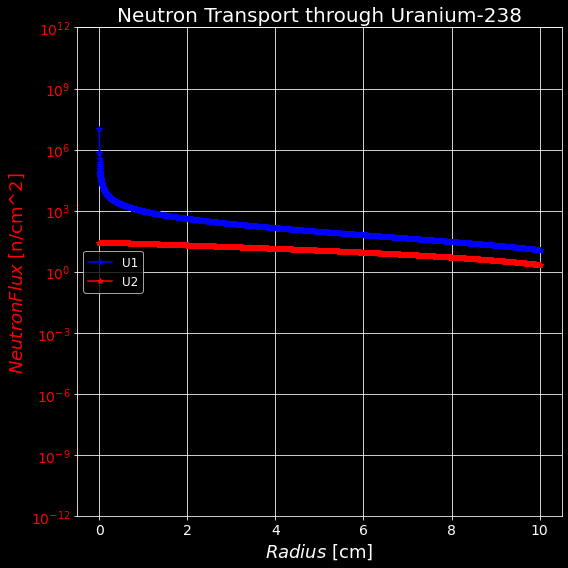

In [66]:
import pandas as pd
!rm output2G*.csv
df = pd.read_csv('output1G_x-data_0002.csv')
plot_solution(df, title='Neutron Transport through Uranium-238', basis_functions_type='Linear Lagrange', flux_basis_functions_type='Constant Monomial')



In [ ]:
def plot_solution_2group(df, 
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    import math
    import numpy as np
    import pandas as pd
    from matplotlib import pyplot as plt
    plt.style.use('dark_background')
    S=10**6
    sigma_s=3.45
    r=np.linspace(.1,100,1000)
    D=1/(sigma_s*(1-2/3))
    sigma_c=0.022
    L=math.sqrt(D/sigma_c)

    y = S*np.exp(-r/L)/(4*np.pi*D*r)
 
    (fig, ax1) = plt.subplots(1, figsize=(8, 8))
    ax1.plot(df['x'], df['u1'],'b*-',label="U1")
    ax1.plot(df['x'], df['u2'],'r*-',label="U2")
    ax1.plot(r, y,'b*-',label='Analytical Solution')
    ax1.set_xlabel(r'$Radius $ [cm]', fontsize=18)
    ax1.set_ylabel(r'$Neutron Flux$ [n/cm^2]', fontsize=18, color='red')

    ax1.set_yscale('log')
    
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    ax1.set_ylim(1e-12,1e12)
    ax1.grid(True)
    
    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

## [Results and Analysis](#toc)<a id="ranalysis"></a>